In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.preprocessing import StandardScaler

pd.set_option('use_inf_as_na', True)
from collections import Counter

from tqdm import tqdm # to measure progress of for loops

/var/folders/sp/wlr6xm2979l8vx6kjh2z1dk00000gn/T/ipykernel_19172/524871555.py:12: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('use_inf_as_na', True)


In [10]:
# load dataset
raw_data = pd.read_pickle('dataset.pkl')
data = raw_data.drop([x  for x in raw_data.columns if 'fqtr' in x],axis=1)
# restrict companies to market cap > 1 billion 
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
# fill in missing values
data.fillna(0.0,inplace=True)

### Insert a column in dataset based on stock performance
Inserting a column in the dataset where entries are:  
- 1 if the stock return is more than 5% higher than the SPY return  
- 0 if it is between -10% and +5% relative to the SPY return  
- -1 if it is less then -10% relative to the SPY return  

In [11]:
# function to return appropriate values based on performance as detailed above
def f(x):
    if x > 0.05:
        return 1
    elif x < -0.1:
        return -1
    else:
        return 0

In [12]:
# add the new column
data['rel_performance'] = data['pred_rel_return'].apply(f)
# make the date the index
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

In [13]:
data[['pred_rel_return', 'rel_performance']][100:110]

,pred_rel_return,rel_performance
date,,
2000-04-03,0.261336,1
2000-04-05,-0.337466,-1
2000-04-06,0.272372,1
2000-04-07,-0.645219,-1
2000-04-07,0.192161,1
2000-04-11,0.153474,1
2000-04-11,0.317203,1
2000-04-11,-0.051039,0
2000-04-11,0.028730,0


In [14]:
print(data.index)

DatetimeIndex(['2000-02-09', '2000-02-09', '2000-02-10', '2000-02-11',
               '2000-02-15', '2000-02-16', '2000-02-16', '2000-02-16',
               '2000-02-16', '2000-02-16',
               ...
               '2018-12-21', '2018-12-21', '2018-12-21', '2018-12-21',
               '2018-12-21', '2018-12-21', '2018-12-21', '2018-12-21',
               '2018-12-21', '2018-12-24'],
              dtype='datetime64[ns]', name='date', length=111468, freq=None)


### Split the data into training, validation, and test
- Data for training period is from 2007 to 2009 (inclusive, i.e. 3 years)
- Data for validation period is 1 quarter after end of training period
- Data for test period is immediately proceeding the training period

In [15]:
df_1 = data.loc['2007-01-01':'2010-01-01']
df_valid = data.loc['2010-04-01':'2010-07-01']
df_test = data.loc['2010-07-01':'2010-10-01']

In [16]:
train_1 = df_1.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

valid = df_valid.reset_index().drop(['ticker','date',
                                    'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)
test = df_test.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

In [17]:
# Obtain the y values for each data split
train_1_stock_returns = df_1['next_period_return']
valid_stock_returns = df_valid['next_period_return']
test_stock_returns = df_test['next_period_return']

y_1 = df_1['rel_performance']
y_valid = df_valid['rel_performance']
y_test = df_test['rel_performance']

y_1 = y_1.values
y_valid = y_valid.values
y_test = y_test.values

### Import Optuna to find the optimal hyperparameters for the classifiers

In [18]:
import optuna
from optuna.trial import Trial
# optuna.logging.set_verbosity(optuna.logging.FATAL)
import warnings
warnings.filterwarnings("ignore")

## Defining the Optuna objective function for our 3 classifiers:
- DecisionTree classifier
- Bagging classifier
- RandomForest classifier

Note that in each case we are optimizing for the profit rather than the accuracy

In [30]:
def objective_rf(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    rf_n_estimators = trial.suggest_int('n_estimators', 10,40,step=5)
    rf_max_features = trial.suggest_categorical('max_features',['sqrt','log2'])
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf',800,2400,step=800)
    rf_max_depth = trial.suggest_int('max_depth',4,15)
    
    rf_clf = RandomForestClassifier(n_estimators=rf_n_estimators,
                                    max_depth=rf_max_depth,
                                    min_samples_leaf=rf_min_samples_leaf,
                                    max_features=rf_max_features)
    rf_clf.fit(train,labels)

    preds = rf_clf.predict(val)
    profit = (preds * val_rets).sum()
 
    return profit

In [31]:
study_rf = optuna.create_study(direction="maximize")

[I 2024-02-04 14:33:46,623] A new study created in memory with name: no-name-f0a1ea6a-71bf-4f6f-9a12-0e63ba9e32e7


### Run optimizations to find optimal parameters

In [32]:
from functools import partial

In [33]:
%%time
study_rf.optimize(partial(objective_rf,train=train_1,labels=y_1,val=valid,val_labels=y_valid,val_rets=valid_stock_returns), n_trials=200,n_jobs=-1)

[I 2024-02-04 14:33:51,190] Trial 0 finished with value: -41.075234000000044 and parameters: {'n_estimators': 15, 'max_features': 'log2', 'min_samples_leaf': 2400, 'max_depth': 14}. Best is trial 0 with value: -41.075234000000044.
[I 2024-02-04 14:33:51,195] Trial 5 finished with value: -40.66695600000005 and parameters: {'n_estimators': 10, 'max_features': 'log2', 'min_samples_leaf': 2400, 'max_depth': 7}. Best is trial 5 with value: -40.66695600000005.
[I 2024-02-04 14:33:51,249] Trial 9 finished with value: -38.84141300000004 and parameters: {'n_estimators': 10, 'max_features': 'log2', 'min_samples_leaf': 800, 'max_depth': 8}. Best is trial 9 with value: -38.84141300000004.
[I 2024-02-04 14:33:51,381] Trial 4 finished with value: -41.60804900000004 and parameters: {'n_estimators': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2400, 'max_depth': 15}. Best is trial 9 with value: -38.84141300000004.
[I 2024-02-04 14:33:51,430] Trial 10 finished with value: -38.56724700000004 and para

CPU times: user 52.7 s, sys: 6.36 s, total: 59.1 s
Wall time: 11.5 s


### Instantiate the classifiers with the best parameters

In [34]:
print("Best parameters for random forest: ", study_rf.best_params)

Best parameters for random forest:  {'n_estimators': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1600, 'max_depth': 15}


In [35]:
rf_clf = RandomForestClassifier(**study_rf.best_params)

### Train each of the classifiers

In [42]:
rf_clf.fit(train_1,y_1)

RandomForestClassifier(max_depth=15, min_samples_leaf=1600, n_estimators=20)

In [43]:
preds=rf_clf.predict(valid)

In [44]:
valid_profit = (preds * df_valid['next_period_return']).sum()
valid_profit

-38.59128500000004

In [45]:
pred_test=rf_clf.predict(test)
test_profit = (pred_test * df_test['next_period_return']).sum()
test_profit

99.11254199999999

In [46]:
accuracy_score(preds,y_valid)

0.3851492019430951

In [47]:
accuracy_score(pred_test,y_test)

0.4852198990627253

### Back test the performance of the models over the period 2010 - 2018

In [71]:
start_dates = [pd.to_datetime('2010-01-01') + pd.DateOffset(months = 3*i) for i in range(21)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]
# So the first period is [2010 Jan 1 - 2013 Jan 1], and the last period is [2015 Jan 1 - 2018 Jan 1]

In [72]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]
test_frames = [data.loc[d + pd.DateOffset(months=6):d+pd.DateOffset(months = 9)] for d in end_dates]

training_labels = [d['rel_performance'].values for d in training_frames]

training_stock_returns = [d['next_period_return'].values for d in training_frames]
test_stock_returns = [d['next_period_return'] for d in test_frames]

In [73]:
training_data = [df.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance', 'pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for df in training_frames]
valid_data = [df.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for df in valid_frames]
test_data = [df.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for df in test_frames]

In [38]:
# dictionary to store performance and returns
xs = {'rf':[1]}
rets = {'rf':[]}
models = {'rf':rf_clf}

for i in tqdm(range(len(start_dates)-1)):
    for key, model in models.items():
        model.fit(training_data[i],training_labels[i])
        
        preds = model.predict(test_data[i])
        profit_i = (preds*test_stock_returns[i]).sum()
        
        rets[key].append(profit_i)
        num_names = len(test_data[i])
        xs[key].append(xs[key][i] + (xs[key][i]/num_names)*profit_i)


100%|███████████████████████████████████████████| 20/20 [03:52<00:00, 11.64s/it]


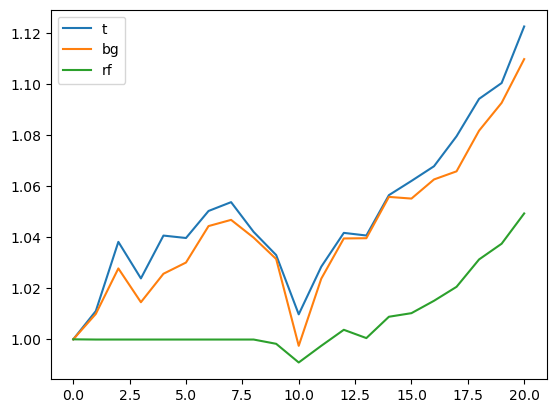

In [39]:
for key, x_list in xs.items():
    plt.plot(x_list, label = key);
plt.legend()

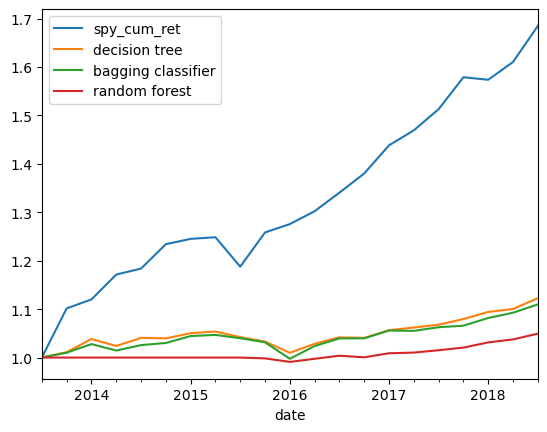

In [40]:
# Compare to buy and hold of SPY
SPY = pd.read_pickle(r'SPY_cum_ret.pkl')
SPY = SPY.loc['2013-07-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0]+1)
SPY['decision tree'] = xs['t']
SPY['bagging classifier'] = xs['bg']
SPY['random forest'] = xs['rf']
SPY.plot();

### Now we can compute the Shapley values for these models and see how the performance changes

### Finding the features with non zero Shapley values

In [41]:
# Retrain the models using the original training set (i.e. before backtesting)
# rf_clf.fit(train_1,y_1)

RandomForestClassifier(max_depth=5, min_samples_leaf=1600, n_estimators=20)

In [48]:
# Obtain the feature importances
def randomforest_feat_importances(m, df):
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp': m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

In [51]:
rf_fi = randomforest_feat_importances(rf_clf,train_1)

In [52]:
# Only use features that have positive feature importance
rf_features = rf_fi[(rf_fi['feat_imp'] > 0.00)]

In [55]:
rf_features.shape

(48, 2)

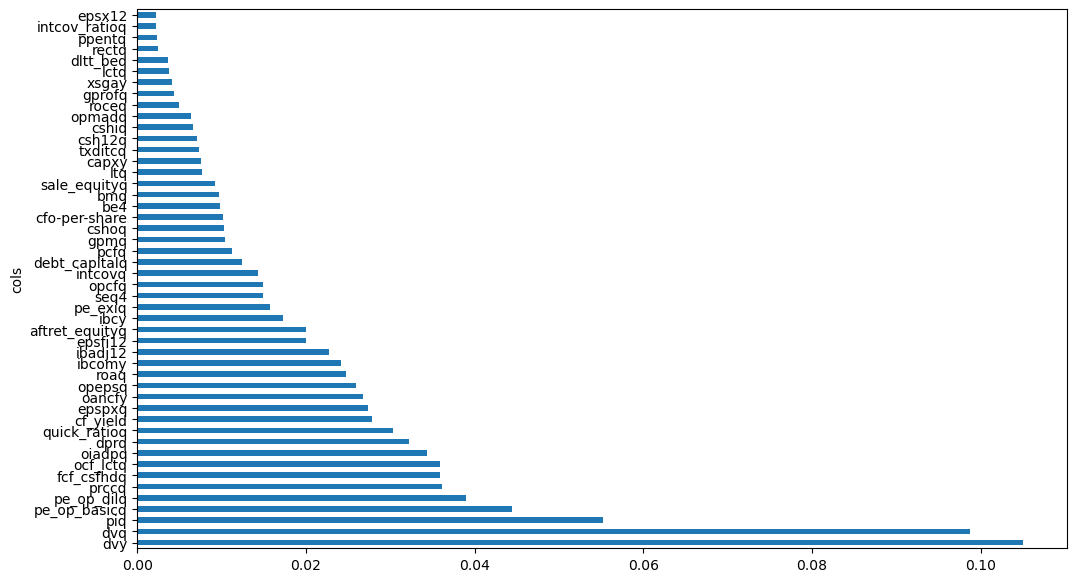

In [57]:
plot_fi(rf_features);

In [58]:
train_1 = train_1[rf_features['cols'].values]
valid = valid[rf_features['cols'].values]

In [59]:
# Retrain the classifiers using the new feature set
rf_clf.fit(train_1,y_1)
rf_clf.score(train_1,y_1)

0.4398608349900596

In [61]:
valid_1 = valid.copy()
valid_1['returns'] = valid_stock_returns.values

In [62]:
import shap

def model(features):
    tree_features = features[features.columns[:-1].values]

    pred = rf_clf.predict(tree_features)

    ret = pred * features[features.columns[-1]]

    return ret

PermutationExplainer explainer: 1442it [04:19,  5.37it/s]                       


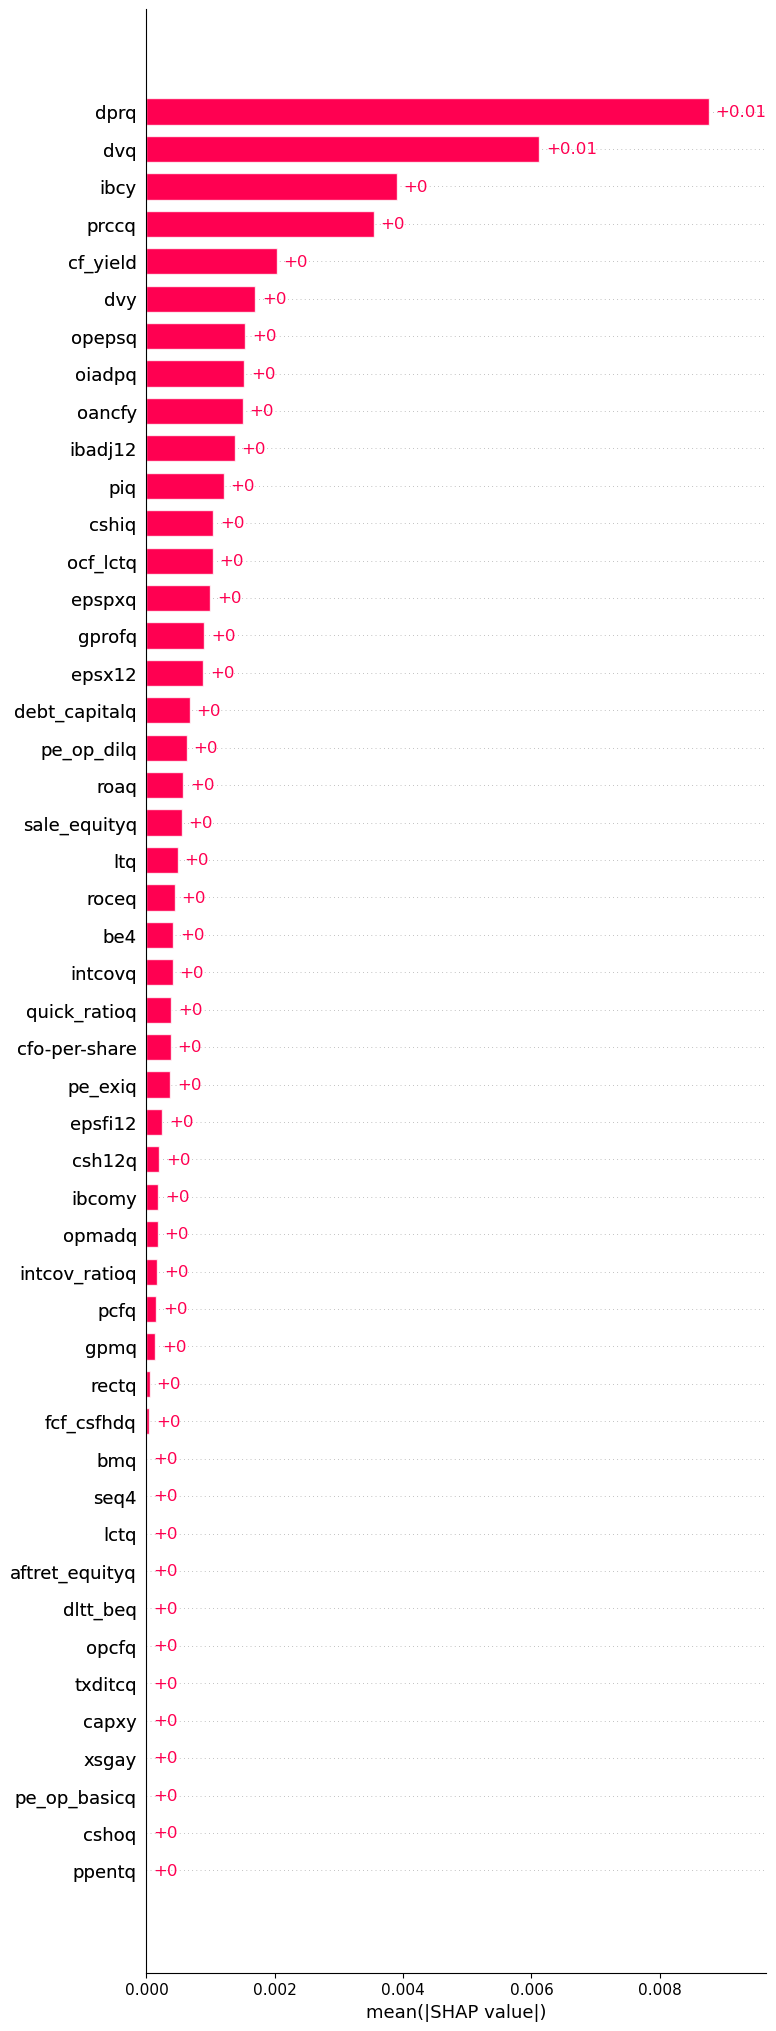

In [63]:
model(valid_1)
explainer = shap.explainers.Permutation(model,valid_1)
shap_values = explainer(valid_1,max_evals=2000)
shap.plots.bar(shap_values[:,:-1],max_display=60)

### Retrain the models with the features that have non-zero Shapley values

In [67]:
rf_cols = rf_features['cols'].values
rf_shap_cols = rf_cols[np.abs(shap_values[:,:-1].values).mean(axis=0)>0.000]

In [68]:
len(rf_shap_cols)

42

In [69]:
# Retrain the classifiers using the new feature set
# rf_clf.fit(train_rf[rf_shap_cols],y_1)

### Back test over the period 2010 - 2018

In [74]:
scalers = [StandardScaler() for _ in range(len(training_data))]

def get_opt_data(shap_cols):
    opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(training_data))]
    opt_valid_data = [pd.DataFrame(scalers[i].transform(valid_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(valid_data))]
    opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(test_data))]
    return opt_training_data, opt_valid_data, opt_test_data

rf_opt_training_data, rf_opt_valid_data, rf_opt_test_data = get_opt_data(rf_shap_cols)

In [75]:
len(rf_features)

48

In [79]:
# dictionary to store performance and returns
opt_xs = [1]
opt_rets = []

for i in tqdm(range(len(start_dates)-1)):
    rf_clf.fit(rf_opt_training_data[i],training_labels[i])
    
    preds = rf_clf.predict(rf_opt_test_data[i])
    profit_i = (preds*test_stock_returns[i]).sum()
    
    opt_rets.append(profit_i)
    num_names = len(rf_opt_test_data[i])
    opt_xs.append(opt_xs[i] + (opt_xs[i]/num_names)*profit_i)

100%|███████████████████████████████████████████| 20/20 [00:10<00:00,  1.91it/s]


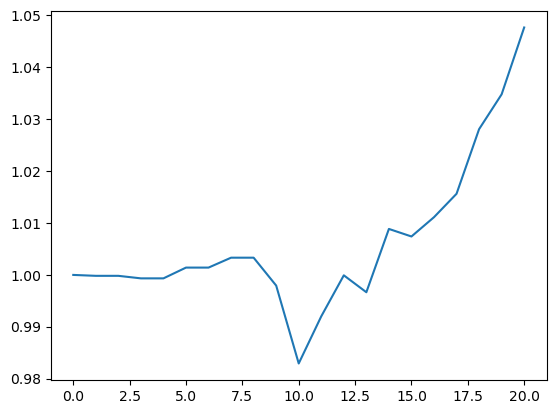

In [84]:
for x_list in [opt_xs]:
    plt.plot(x_list);

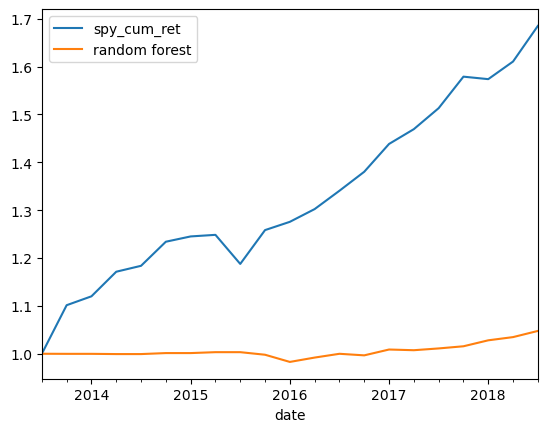

In [83]:
# Compare to buy and hold of SPY
SPY = pd.read_pickle(r'SPY_cum_ret.pkl')
SPY = SPY.loc['2013-07-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0]+1)
SPY['random forest'] = opt_xs
SPY.plot();

In [83]:
t_clf.fit(train_1,y_1)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=700, random_state=123)

In [ ]:
preds=rf_clf.predict(valid)

In [ ]:
valid_profit = (preds * df_valid['next_period_return']).sum()
valid_profit

In [ ]:
pred_test=rf_clf.predict(test)

In [ ]:
test_profit = (pred_test * df_test['next_period_return']).sum()
test_profit

In [ ]:
confusion_matrix(y_test,pred_test)

In [ ]:
accuracy_score(preds,y_valid)

In [ ]:
accuracy_score(pred_test,y_test)

In [ ]:
len(train_1.columns)

In [ ]:
def randomforest_feat_importances(m, df):
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp': m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

In [ ]:
fi = randomforest_feat_importances(rf_clf,train_1)

In [ ]:
features = fi[(fi['feat_imp'] > 0.00)]

In [ ]:
features.shape

In [ ]:
plot_fi(features);

In [ ]:
features

In [ ]:
train_1 = train_1[features['cols'].values]
valid = valid[features['cols'].values]

In [ ]:
rf_clf.fit(train_1,y_1)
rf_clf.score(train_1,y_1)

In [ ]:
len(valid)

In [ ]:
pred_valid = rf_clf.predict(valid)
rf_clf.score(valid,y_valid)

In [ ]:
(pred_valid * valid_stock_returns).sum()

In [ ]:
Counter(pred_valid)

In [ ]:
valid_1 = valid.copy()

In [ ]:
valid_1['returns'] = valid_stock_returns.values

In [ ]:
import shap

In [ ]:
def model(features):
    tree_features = features[features.columns[:-1].values]

    pred = rf_clf.predict(tree_features)

    ret = pred * features[features.columns[-1]]

    return ret

In [ ]:
model(valid_1)

In [ ]:
explainer = shap.explainers.Permutation(model,valid_1)

In [ ]:
shap_values = explainer(valid_1,max_evals=2000)

In [ ]:
shap.plots.bar(shap_values[:,:-1],max_display=60)

In [ ]:
cols = features['cols'].values

In [ ]:
shap_cols = cols[np.abs(shap_values[:,:-1].values).mean(axis=0)>0.000]

In [ ]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3 * i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]
test_frames = [data.loc[d + pd.DateOffset(months=6):d+pd.DateOffset(months = 9)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]
valid_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in test_frames]

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scalers = [StandardScaler() for _ in range(len(training_data))]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(training_data))]
opt_valid_data = [pd.DataFrame(scalers[i].transform(valid_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(valid_data))]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(test_data))]

In [ ]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        rf_clf.fit(opt_training_data[i],training_labels[i])

        preds = rf_clf.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)


In [ ]:
plt.plot(x);

In [ ]:
SPY = pd.read_pickle(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 2\SPY_cum_ret.pkl')
SPY = SPY.loc['2004-07-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0]+1)
SPY['strategy'] = x

In [ ]:
SPY.plot();

In [ ]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

In [ ]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

In [ ]:
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_std

In [ ]:
(SPY['spy_cum_ret'] - 1).diff().mean()
(SPY['spy_cum_ret'] - 1).diff().std()
print('SP Sharpe Ratio: ',(SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std())

In [ ]:
x[-1]

In [ ]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

In [ ]:
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
IR

In [ ]:
alpha = np.mean(residual_ret)
alpha

In [ ]:
def profit_importance(m,df,rets):
#     np.random.seed(123)
    profit = []
    for col in df.columns:
        prof = []
        for _ in range(100):
            X = df.copy()
            X[col] = np.random.permutation(df[col].values)
            prediction = m.predict(X)
            prof.append((prediction * rets).sum())
        profit.append(np.mean(prof))
    return profit

In [ ]:
def randomforest_profit_importance(m, df,rets):
    return pd.DataFrame({'cols':df.columns, 'pi_imp':profit_importance(m,df,rets)}
                       ).sort_values('pi_imp', ascending=True)

In [ ]:
pi = randomforest_profit_importance(rf_clf,valid,valid_stock_returns)
pi

In [ ]:
%%time
profits = []
feat=[]

train = train_1.copy()
validation = valid.copy()

while len(train.columns)>1:

    col_to_drop = pi.iloc[-1]['cols']
    train.drop(col_to_drop,axis=1,inplace=True)
    validation.drop(col_to_drop,axis=1,inplace=True)
        
    rf_clf.fit(train,y_1)
    pi = randomforest_profit_importance(rf_clf,validation,df_valid['next_period_return'])

    pred_valid = rf_clf.predict(validation)
        
    print((pred_valid * df_valid['next_period_return']).sum())
    profits.append((pred_valid * df_valid['next_period_return']).sum())
    feat.append(train.columns)

In [ ]:
plt.plot(profits);

In [ ]:
n = np.argmax(profits)
profits[n]

In [ ]:
n

In [ ]:
optim_feats = feat[n]
optim_feats


In [ ]:
train_1_optim = train_1[optim_feats]
valid_optim = valid[optim_feats]


rf_clf.fit(train_1_optim,y_1)
print(rf_clf.score(train_1_optim,y_1))
pred_valid = rf_clf.predict(valid_optim)
print(rf_clf.score(valid_optim,y_valid))
(pred_valid * valid_stock_returns).sum()

In [ ]:
confusion_matrix(pred_valid,y_valid)

In [ ]:
Counter(y_valid)

In [ ]:
Counter(pred_valid)

## Long term performance with Random Forest Classifier, optimal hyper-parameters

In [ ]:
start_dates = [pd.to_datetime('2000-01-01') + pd.DateOffset(months = 3 * i) for i in range(62)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [ ]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d:d+pd.DateOffset(months = 3)] for d in end_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 6):d+pd.DateOffset(months = 9)] for d in end_dates]

In [ ]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

In [ ]:
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

In [ ]:
training_labels = [d['rel_performance'].values for d in training_frames]

In [ ]:
opt_training_data = [t[optim_feats] for t in training_data]
opt_test_data = [v[optim_feats] for v in test_data]

In [ ]:
P_L = []
x = [1]
ret = []

for i in range(len(training_labels)):
        rf_clf.fit(opt_training_data[i],training_labels[i])
        pred_i = rf_clf.predict(opt_test_data[i])
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        num_positions = len(pred_i)
        ret.append((1.0/num_positions) * profit_i)
        x.append(x[i] + (x[i]/num_positions) * profit_i)

In [ ]:
plt.plot(x);

In [ ]:
len(x)

In [ ]:
SPY = pd.read_pickle(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 2\SPY_cum_ret.pkl')
SPY = SPY.loc['2003-01-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

In [ ]:
SPY.plot();

In [ ]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

In [ ]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

In [ ]:
x[-1]

In [ ]:
SPY['spy_cum_ret'][-1]

In [ ]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

In [ ]:
beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]

In [ ]:
beta

In [ ]:
residual_ret = strategy_ret - beta * spy_ret

In [ ]:
IR = np.mean(residual_ret)/np.std(residual_ret)

In [ ]:
IR

In [ ]:
alpha = np.mean(residual_ret)

In [ ]:
alpha

## Compute optimal features each quarter

In [ ]:
import _pickle as cPickle

In [ ]:
with open(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 5\opt_feat_4.pkl','rb') as f:
    optimal_features = cPickle.load(f)

In [ ]:
optimal_features

In [ ]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

In [ ]:
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]

In [ ]:
optimal_features

In [ ]:
len(optimal_features)

In [ ]:
rf_clf = RandomForestClassifier(**{'n_estimators': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1600,
 'max_depth': 10})

In [ ]:
P_L = []
x = [1]
ret = []

for i in range(len(optimal_features)-1):
        rf_clf.fit(training_data[i][optimal_features[i-1]],training_labels[i])
        pred_i = rf_clf.predict(test_data[i][optimal_features[i-1]])
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        num_positions = len(pred_i)
        ret.append((1.0/num_positions) * profit_i)
        x.append(x[i] + (x[i]/num_positions) * profit_i)

In [ ]:
plt.plot(x[1:]);

In [ ]:
SPY = pd.read_pickle(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 2\SPY_cum_ret.pkl')
SPY = SPY.loc['2003-07-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

In [ ]:
SPY.plot();

In [ ]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

In [ ]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

In [ ]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

In [ ]:
beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

## Compute both optimal hyper-parameters and optimal features at each quarter

In [ ]:
start_dates = [pd.to_datetime('2000-01-01') + pd.DateOffset(months = 3 * i) for i in range(62)]
end_dates = [d + pd.DateOffset(months = 35) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
validation_frames = [data.loc[d:d+pd.DateOffset(months = 3)] for d in end_dates]
test_frames = [data.loc[d + pd.DateOffset(months=6):d+pd.DateOffset(months = 9)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]
validation_data = test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in validation_frames]
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in validation_frames]

In [ ]:
len(data.columns)

In [ ]:
%%time
optimal_features = []
classifiers = []

for i in range(len(training_data)):
    print(i)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(partial(objective,train=training_data[i],
                           labels=training_labels[i],
                           val=validation_data[i],
                           val_labels=validation_labels[i],
                           val_rets = validation_frames[i]['next_period_return']),
                           n_trials=100,n_jobs=-1)
    params = study.best_params
    
    print(params)
    
    rf_clf = RandomForestClassifier(**params)

    classifiers.append(rf_clf)
    
    rf_clf.fit(training_data[i],training_labels[i])
    fi = randomforest_feat_importances(rf_clf,training_data[i])
    features = fi[fi['feat_imp'] > 0.005]
    
    train = training_data[i][features['cols'].values].copy()
    validation = validation_data[i][features['cols'].values].copy()
    
    
    profits = []
    feat=[]
    
    rf_clf.fit(train,training_labels[i])
    
    while len(train.columns)>1:
        
        pi = randomforest_profit_importance(rf_clf,validation,validation_frames[i]['next_period_return'])

        col_to_drop = pi.iloc[-1]['cols']
        train.drop(col_to_drop,axis=1,inplace=True)
        validation.drop(col_to_drop,axis=1,inplace=True)
        
        rf_clf.fit(train,training_labels[i])
        pred_valid = rf_clf.predict(validation)
        profits.append((pred_valid * validation_frames[i]['next_period_return']).sum())
        feat.append(train.columns)
        
    n = np.argmax(profits)

    max_profits = profits[n]

    optim_feats = feat[n]
    
    print(optim_feats)
    print(max_profits)

    optimal_features.append(optim_feats)

In [ ]:
with open('opt_feat_11.pkl','rb') as f:
    optimal_features = pickle.load(f)

In [ ]:
with open('classifiers_11.pkl','rb') as f:
    classifiers = pickle.load(f)

In [ ]:
P_L = []
x = [1]
ret = []

for i in range(len(optimal_features)-1):

        classifiers[i-1].fit(training_data[i][optimal_features[i-1]],training_labels[i])
        pred_i = classifiers[i-1].predict(test_data[i][optimal_features[i-1]])
        
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        positions = np.sum(np.abs(pred_i))
        
        ret.append((1.0/positions) * profit_i)
        x.append(x[i] + (x[i]/positions) * profit_i)

In [ ]:
plt.plot(x);

In [ ]:
SPY = pd.read_pickle(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 2\SPY_cum_ret.pkl')
SPY = SPY.loc['2003-07-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

In [ ]:
SPY.plot();

In [ ]:
SPY.tail()

In [ ]:
SPY = SPY.resample('A').bfill()

In [ ]:
SPY.plot();

In [ ]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

In [ ]:
(SPY['spy_cum_ret'] - 1).diff().mean()
(SPY['spy_cum_ret'] - 1).diff().std()
print('SP Sharpe Ratio: ',(SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std())

In [ ]:
avr = np.exp(np.log(x[-1])/15.) - 1
print('Average annual return: ',avr)
sp_avr = np.exp(np.log(SPY['spy_cum_ret'][-1])/15) - 1
print('SPY average annual return: ', sp_avr)

In [ ]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]
beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
print('beta: ',beta)
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
print('Information Ratio: ',IR)

In [ ]:
alpha = np.mean(residual_ret)
print('Strategy alpha: ',alpha)

In [ ]:
starting_year='2010'
a = SPY.loc[starting_year]['spy_cum_ret'].values
b = SPY.loc[starting_year]['strategy'].values
plt.plot(SPY.loc[starting_year:]['spy_cum_ret'] - a + 1);
plt.plot(SPY.loc[starting_year:]['strategy'] - b + 1);

In [ ]:
def max_drawdown(returns):
        local_max = [n for n in range(len(returns)-1) if ((n==0) and (returns[0] > returns[1])) or 
           ((n > 0) and  (returns[n-1]<returns[n]) and (returns[n+1]<returns[n]))] 
        
        local_min = [n for n in range(1,len(returns)) if ((n == len(returns)-1) and (returns[-1] < returns[-2])) or
                (returns[n-1]>returns[n]) and (returns[n+1]>returns[n])]
        
        def next_local_min(n):
            if [m for m in local_min if m > n]:
                return [m for m in local_min if m > n][0]
            else: return None
        
        drawdowns = [(n,next_local_min(n)) for n in local_max]
        drawdown_values = [returns[n] - returns[m] for (n,m) in drawdowns if m != None]
        if drawdown_values:
            return  np.max(drawdown_values)
        else: return 0.0

In [ ]:
max_drawdown(SPY['strategy'])

In [ ]:
max_drawdown(SPY['spy_cum_ret'])